# CPM Routing Optimization

# Load up the data 
* Demands = number of unpaid + expired
* locations = x,y coordinates of block
* labels = block id
* cars = average number of cars

## Data is from March 2017 to March 2018

In [1]:
import csv
demands = []
labels = []
locations = []
firstLine = True
limiter = 9999999
counter = 0
cars = []
with open('Copy of blocks_com_031318.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if counter < limiter: #this is just a cap to QA the model with fewer locations
            if firstLine:
                firstLine = False
            else:
                latLong = []
                latLong.append(float(row[13]))
                latLong.append(float(row[14]))
                locations.append(latLong)
                labels.append(row[0])
                demands.append(float(row[17]))
                cars.append(float(row[16]))
                counter+=1


start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)

In [17]:
import pandas as pd
dictionary = {'Block ID': labels, 'Unpaid and Expired Average': demands, 'Locations': locations}

df = pd.DataFrame.from_dict(dictionary)
df.head()

,Block ID,Locations,Unpaid and Expired Average
0,B926105,"[442729.549, 4645729.248]",0.246201
1,B506106,"[436795.6734, 4646779.378]",0.386905
2,B508116,"[436727.2619, 4649718.953]",0.264000
3,B258308,"[445548.827, 4636840.169]",0.574545
4,B324210,"[444430.2199, 4643295.969]",0.639860


# Next step - find optimal clusters of blocks for car drop-off
## Plotting locations below

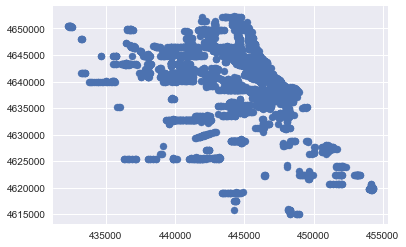

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
seed = 1234 # setting seed to keep results the same run to run
plt.scatter([x[0] for x in locations], [x[1] for x in locations], s=50)

# Below we are trying to find the optimal number of clusters. 
This is found by iterating through clusters 1-50 and looking at the average number of blocks + the average distance of blocks from the center starting point of the cluster.

In [22]:
# Elbow chart
from scipy.cluster.vq import vq
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans


X = np.array(zip([x[0] for x in locations],[x[1] for x in locations]))


distortions = []
avgBinsize = []
K = range(20,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=seed).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])
    centers = kmeanModel.cluster_centers_
    idx,_ = vq(X,centers) #finding the number of blocks by cluster
    avgBinsize.append(np.average(np.bincount(idx)))

[(20, 199.25, 1198.6758672407134), (21, 189.76190476190476, 1144.477351867956), (22, 181.13636363636363, 1123.6577359859543), (23, 173.2608695652174, 1091.9529643372275), (24, 166.04166666666666, 1061.1378340658976), (25, 159.40000000000001, 1029.8545529499663), (26, 153.26923076923077, 1010.2581731400946), (27, 147.59259259259258, 977.00519415215911), (28, 142.32142857142858, 948.44151255120528), (29, 137.41379310344828, 922.78908915974966), (30, 132.83333333333334, 916.16128212730052), (31, 128.54838709677421, 889.49238479600535), (32, 124.53125, 857.76210555020884), (33, 120.75757575757575, 843.66794071578477), (34, 117.20588235294117, 827.12526956449483), (35, 113.85714285714286, 801.12449372126127), (36, 110.69444444444444, 790.47441644065395), (37, 107.70270270270271, 774.596367638792), (38, 104.86842105263158, 770.88594662891728), (39, 102.17948717948718, 757.97182152068683), (40, 99.625, 726.58163662923414), (41, 97.195121951219505, 721.21044770720277), (42, 94.88095238095238, 

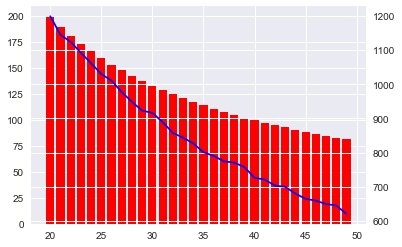

In [23]:
plt.bar(K, avgBinsize, color='r')
# for kb in zip(K,avgBinsize):
#     plt.annotate('{}'.format(kb), xy=kb, textcoords='data')
axes2 = plt.twinx()

plt.plot(K, distortions, 'bx-')
print(zip(K,avgBinsize, distortions))


# Now we are choosing the number of clusters and slicing the data by cluster
## kData is the data structure that will be used to hold the data by cluster, and eventually the solution
* center = the x,y coord that is the center of the cluster
* locations = the locations by cluster
* labels = block id by cluster
* cars = number of parked cars by cluster
* demand = number of unpaid + expired by cluster
* centralTerm = the blockID closest to the center

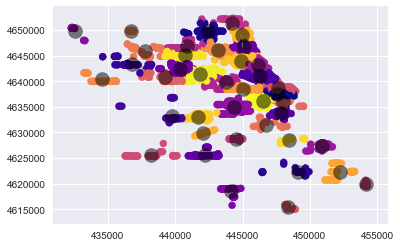

In [6]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
seed = 1234
X = np.array(zip([x[0] for x in locations],[x[1] for x in locations]))

nClusters = 40
kmeans = KMeans(n_clusters=nClusters, random_state=seed)
kmeans.fit(X)

kPred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=kPred, s=50, cmap='plasma')


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# print np.average(np.bincount(idx))
closest, _ = pairwise_distances_argmin_min(centers, X)
centerTerminals = [labels[c] for c in closest]
kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
              'centralTerm': None} for key in range(nClusters)}
# kData = {}
for k in range(nClusters):
    klocations = []
    klabels = []
    kcars = []
    kdemand = []
    for loc, lab, car, dem, kp in zip(locations, labels, cars, demands, kPred):
        if kp == k:
            klocations.append(loc)
            klabels.append(lab)
            kcars.append(car)
            kdemand.append(dem)
#     print(len(klocations))
    kData[k].update({'center':centers[k], 'locations': klocations, 'labels': klabels, 'cars' : kcars, 'demand': kdemand, 'centralTerm' : centerTerminals[k]})
            
# kData[0]

In [46]:
#save cluster data to csv

filename = "clusterFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv"

se = pd.Series(kPred)

df['cluster'] = se.values

df.to_csv(filename)

# Create objects and callback functions for optimization algorithm
* distance = manhattan distance function
* distanceCallback = distance function from previous to current block
* demandCallback = get the paid + unpaid for the current block
* ServiceTimeCallback = get the time per ticket written
* CarCheckCallback = get the time it takes to check each indivisual car
* travelTimeCallback = get the travel time from node to node assuming a speed
* totalTimeCallback = the total time for the block, adding the various time callbacks + block overhead time assumptions

In [7]:
import math
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def distance(x1, y1, x2, y2):
    # Manhattan distance
    dist = abs(x1 - x2) + abs(y1 - y2)

    return dist

# Distance callback

class CreateDistanceCallback(object):
  """Create callback to calculate distances and travel times between points."""

  def __init__(self, locations):
    """Initialize distance array."""
    num_locations = len(locations)
    self.matrix = {}

    for from_node in xrange(num_locations):
      self.matrix[from_node] = {}
      for to_node in xrange(num_locations):
#             JSW: THIS ALLOWS O TRAVEL PENALTY FROM DEPOT
#         if from_node == depot or to_node == depot:
#           self.matrix[from_node][to_node] = 0
#         else:
          x1 = locations[from_node][0]
          y1 = locations[from_node][1]
          x2 = locations[to_node][0]
          y2 = locations[to_node][1]
          self.matrix[from_node][to_node] = distance(x1, y1, x2, y2)

  def Distance(self, from_node, to_node):
     return self.matrix[from_node][to_node]


# Demand callback
class CreateDemandCallback(object):
  """Create callback to get demands at location node."""

  def __init__(self, demands):
    self.matrix = demands

  def Demand(self, from_node, to_node):
    return self.matrix[from_node]

# Service time (proportional to demand) callback.
class CreateServiceTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, demands, time_per_demand_unit):
    self.matrix = demands
    self.time_per_demand_unit = time_per_demand_unit

  def ServiceTime(self, from_node, to_node):
#     return int(self.matrix[from_node] * self.time_per_demand_unit)
    return self.matrix[from_node] * self.time_per_demand_unit

######JSW ADD BLOCK OVERHEAD TIME

class CreateBlockOverheadTime(object):
  """Create callback to get overhead time for each block."""

  def __init__(self, overhead_time):
    self.matrix = demands
    self.overhead_time = overhead_time

  def BlockOverheadTime(self, from_node, to_node):
    return int(self.overhead_time)


####################

######JSW ADD NONVIOLATOR CHECK TIME
# Service time (proportional to demand) callback.
class CreateCarCheckTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, cars, time_per_car_unit):
    self.matrix = cars
    self.time_per_car_unit = time_per_car_unit

  def ServiceTime(self, from_node, to_node):
    return int(self.matrix[from_node] * self.time_per_car_unit)
#####################################

# Create the travel time callback (equals distance divided by speed).
class CreateTravelTimeCallback(object):
  """Create callback to get travel times between locations."""

  def __init__(self, dist_callback, speed):
    self.dist_callback = dist_callback
    self.speed = speed

  def TravelTime(self, from_node, to_node):
    travel_time = self.dist_callback(from_node, to_node) / self.speed
    return int(travel_time)
# Create total_time callback (equals service time plus travel time).
class CreateTotalTimeCallback(object):
  """Create callback to get total times between locations."""

  def __init__(self, service_time_callback, travel_time_callback, car_check_time_callback, \
              overhead_time_callback):
    self.service_time_callback = service_time_callback
    self.travel_time_callback = travel_time_callback
    self.car_check_time_callback = car_check_time_callback
    self.overhead_time_callback = overhead_time_callback

  def TotalTime(self, from_node, to_node):
    service_time = self.service_time_callback(from_node, to_node)
    travel_time = self.travel_time_callback(from_node, to_node)
    car_check_time = self.car_check_time_callback(from_node, to_node)
    overhead_time = self.overhead_time_callback(from_node, to_node)
    return service_time + travel_time + car_check_time + overhead_time

def get_routes_array(assignment, num_routes, routing):
  # Get the routes for an assignent and return as a list of lists.
  routes = []
  for route_nbr in range(num_routes):
    node = routing.Start(route_nbr)
    route = []

    while not routing.IsEnd(node):
      node = assignment.Value(routing.NextVar(node))
      route.append(node)
    routes.append(route)
  return routes

In [8]:
#creating objects for function to work below
depot = 0
labs = ['a','b']

# Below is the optimization algorithm and function
## key parameters:
* locations = list of locations
* demands = paid + unpaid
* start times, end times = the time windows of a given block's availability... currently not used
* num_vehicles = number of enforcement agents
* search time limit = limit in ms of time to find a solution
* time per demand unit = time it takes to write a ticket
* speed = walking speed between blocks
* vehicle capacity = maximum tickets that can be written - not used aka: unlimited
* depot = the index of the block where everyone starts walking for their shift
* horizion = shift duration
* time per car unit = time it takes to check each car (regardles of if there is a ticket)
* labs = block ids
* cars = number of cars

In [9]:
def main(locations=locations, demands=demands, start_times=start_times, end_times=end_times, \
         num_vehicles=30, search_time_limit = 2000,\
        horizon = 6.5 * 3600, time_per_demand_unit = 3*60, speed = 1.34, VehicleCapacity = 999999,\
        depot = depot, time_per_car_unit=1*60, labs=labs, cars=cars, blockOverhead = 2 * 60):

  num_locations = len(locations)

  if num_locations > 0:

    # The number of nodes of the VRP is num_locations.
    # Nodes are indexed from 0 to num_locations - 1. By default the start of
    # a route is node 0.
    routing = pywrapcp.RoutingModel(num_locations, num_vehicles, depot)
    search_parameters = pywrapcp.RoutingModel_DefaultSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING) ## added by jw for search
    search_parameters.time_limit_ms = search_time_limit #added by jsw
    search_parameters.first_solution_strategy = (
                                    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC) #added by jsw
    #JW ADD - make sure all nodes will be reached
    #routing.AddAllActive

    # Callbacks to the distance function and travel time functions here.
    dist_between_locations = CreateDistanceCallback(locations)
    dist_callback = dist_between_locations.Distance

    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    demands_at_locations = CreateDemandCallback(demands)
    demands_callback = demands_at_locations.Demand


    NullCapacitySlack = 0;
    fix_start_cumul_to_zero = True
    capacity = "Unpaid and Overdue"

    routing.AddDimension(demands_callback, NullCapacitySlack, VehicleCapacity,
                         fix_start_cumul_to_zero, capacity)
    # Add time dimension.

    time = "Time"

    service_times = CreateServiceTimeCallback(demands, time_per_demand_unit)
    service_time_callback = service_times.ServiceTime
    
    car_check_time = CreateCarCheckTimeCallback(cars, time_per_car_unit)
    car_check_time_callback = car_check_time.ServiceTime
    
    block_overhead_time = CreateBlockOverheadTime(blockOverhead)
    block_overhead_time_callback = block_overhead_time.BlockOverheadTime

    travel_times = CreateTravelTimeCallback(dist_callback, speed)
    travel_time_callback = travel_times.TravelTime

    total_times = CreateTotalTimeCallback(service_time_callback, travel_time_callback\
                                          , car_check_time_callback, block_overhead_time_callback)
    total_time_callback = total_times.TotalTime

    routing.AddDimension(total_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         fix_start_cumul_to_zero,
                         time)
    # Add time window constraints.
    time_dimension = routing.GetDimensionOrDie(time)
    
#     JSW - removed the time windows
#     for location in range(1, num_locations):
#       start = start_times[location]
#       end = end_times[location]
#       time_dimension.CumulVar(location).SetRange(start, end)
    # Solve displays a solution if any.
    assignment = routing.SolveWithParameters(search_parameters)
    
    if assignment:
      size = len(locations)
      # Solution cost.
      print "Total distance of all routes: " + str(assignment.ObjectiveValue()) + "\n"
      # Inspect solution.
      capacity_dimension = routing.GetDimensionOrDie(capacity);
      time_dimension = routing.GetDimensionOrDie(time);
      solByCar = []
      for vehicle_nbr in range(num_vehicles):
        nodeSolution = []
        ticketLoad = []
        tminArr = []
#         tmaxArr = []
        index = routing.Start(vehicle_nbr)
        plan_output = 'Route {0}:'.format(vehicle_nbr)

        while not routing.IsEnd(index):
          node_index = routing.IndexToNode(index)
          load_var = capacity_dimension.CumulVar(index)
          time_var = time_dimension.CumulVar(index)
          plan_output += \
                    " {node_index} Load({load}) Time({tmin}) -> ".format(
                        node_index=labs[node_index],
                        load=assignment.Value(load_var),
                        tmin=str(assignment.Min(time_var)))
#                         ,
#                         tmax=str(assignment.Max(time_var)))
          index = assignment.Value(routing.NextVar(index))
          nodeSolution.append(labs[node_index])
          ticketLoad.append(assignment.Value(load_var))
          tminArr.append(str(assignment.Min(time_var)))
#           tmaxArr.append(str(assignment.Max(time_var)))

        node_index = routing.IndexToNode(index)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        plan_output += \
                  " {node_index} Load({load}) Time({tmin})".format(
                      node_index=labs[node_index],
                      load=assignment.Value(load_var),
                      tmin=str(assignment.Min(time_var)))
#                       ,
#                       tmax=str(assignment.Max(time_var)))
        print plan_output
        solByCar.append((nodeSolution, ticketLoad, tminArr))
        print "\n"
        print routing.CostVar()
      return solByCar, assignment
    else:
      print 'No solution found.'
  else:
    print 'Specify an instance greater than 0.'

def create_data_array():

  locations = [[820, 760], [960, 440], [500, 50], [490, 80], [130, 70], [290, 890], [580, 300],
               [840, 390], [140, 240], [120, 390], [30, 820], [50, 100], [980, 520], [840, 250],
               [610, 590], [10, 650], [880, 510], [910, 20], [190, 320], [930, 30], [500, 930],
               [980, 140], [50, 420], [420, 90], [610, 620], [90, 970], [800, 550], [570, 690],
               [230, 150], [200, 700], [850, 600], [980, 50]]

  demands =  [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18,
             19, 1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9]

  start_times =  [0] * len(demands)

  # tw_duration is the width of the time windows.
#   tw_duration = 60 * 24

  # In this example, the width is the same at each location, so we define the end times to be
  # start times + tw_duration. For problems in which the time window widths vary by location,
  # you can explicitly define the list of end_times, as we have done for start_times.
#   start_times =  [0] * len(start_times)
  end_times = [3600 * 24] * len(start_times)

#   for i in range(len(start_times)):
#     end_times[i] = start_times[i] + tw_duration
  data = [locations, demands, start_times, end_times]
  return data
# if __name__ == '__main__':
#   main()

# Below is an example of running the optimization for one cluster

106
B230407
B230407
281
447644.2962


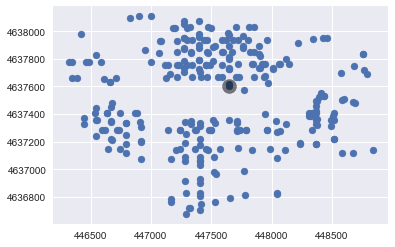

In [10]:
from sklearn.metrics import pairwise_distances_argmin_min # to find closest terminal to center

clustData = kData[0]
loc = clustData['locations']
dem = clustData['demand']
start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
labs = clustData['labels']
depot = labs.index(clustData['centralTerm']) # find the starting drop-off point
ca = clustData['cars']
print(depot)
print(clustData['centralTerm'])
print(labs[106])
print(len(loc))


X = np.array(zip([x[0] for x in loc],[x[1] for x in loc]))

plt.scatter(X[:, 0], X[:, 1])

print(loc[depot][0])
# print(ca)
# print(dem)
# centers = kmeans.cluster_centers_
plt.scatter(loc[depot][0], loc[depot][1], c='black', s=200, alpha=0.5)

# Run the optimization

## Output is in the following format:

Route PERSON ID Load CUMUALTIVE NUMBER OF TICKETS Time SECONDS FROM START -> NEXT NODE

In [18]:
# Establish running parameters of model

params = {'locations': loc, 'demands':dem, 'start_times':start_times, 'end_times':end_times, \
                 'num_vehicles':noEmps, 'search_time_limit': 30000,'horizon' : int(6.4 * 3600), \
                 'time_per_demand_unit' : 2*60, 'speed' : 1.34, 'VehicleCapacity' : 999999,\
                'depot' : depot, 'time_per_car_unit':1*60, 'labs':labs, 'cars' : ca, 'blockOverhead' : 2*60\
        }

In [20]:
solByCar, assignment = main(**params)

Total distance of all routes: 21271

Route 0: starting by termial: B386402 Load(0) Time(0) ->  B386404 Load(0) Time(216) ->  B386412 Load(0) Time(479) ->  B527511 Load(0) Time(1104) ->  B514504 Load(0) Time(1510) ->  B804905 Load(0) Time(2182) ->  B527524 Load(0) Time(2464) ->  B527510 Load(0) Time(2790) ->  B803904 Load(1) Time(3478) ->  B527507 Load(2) Time(3811) ->  B825901 Load(2) Time(4473) ->  B261411 Load(2) Time(4901) ->  B261410 Load(2) Time(5274) ->  B385405 Load(2) Time(5804) ->  B385406 Load(2) Time(6531) ->  B385401 Load(2) Time(6955) ->  B260405 Load(2) Time(7375) ->  B260408 Load(2) Time(7710) ->  B905405 Load(2) Time(8243) ->  B905406 Load(2) Time(8739) ->  B731304 Load(2) Time(9158) ->  B258301 Load(2) Time(9814) ->  B258302 Load(2) Time(10116) ->  B258303 Load(2) Time(10507) ->  B358304 Load(2) Time(11004) ->  B358305 Load(2) Time(11408) ->  B358308 Load(2) Time(12010) ->  B358309 Load(2) Time(12666) ->  B358310 Load(2) Time(13525) ->  B358311 Load(2) Time(14111) ->  

In [33]:
solByCar

[(['B230407'], [0], ['0']),
 (['B230407',
   'B811904',
   'B815904',
   'B230406',
   'B239407',
   'B239408',
   'B239410',
   'B239409',
   'B356403',
   'B815902',
   'B611401',
   'B356407',
   'B200411',
   'B257408',
   'B385408',
   'B385403',
   'B260413',
   'B260412',
   'B260406',
   'B260415',
   'B260414',
   'B260402',
   'B260401',
   'B257418',
   'B257406',
   'B257405',
   'B257407',
   'B385404',
   'B385409',
   'B200413',
   'B200412',
   'B200408',
   'B200409',
   'B200407',
   'B200406',
   'B200401',
   'B200415',
   'B200414',
   'B200403',
   'B200405',
   'B200410',
   'B202403',
   'B202401',
   'B202404',
   'B240402',
   'B240403',
   'B356405',
   'B240405',
   'B240418',
   'B241412',
   'B241401',
   'B241402',
   'B241404',
   'B241407',
   'B241405',
   'B240401',
   'B815913',
   'B241410',
   'B241409',
   'B240404',
   'B240415',
   'B240414',
   'B240409',
   'B240408',
   'B239402',
   'B239403',
   'B239404',
   'B815903',
   'B815906',
   'B2

# How to fix redundant depot visit? create dummy depot staring point based on closest location with 0 ticket demand

# WARNING - DO NOT RUN THIS MORE THAN ONCE, OR IT WILL KEEP APPENDING NEW LIST ITEMS

In [13]:
def getData(cluster):
    clustData = kData[cluster]
    loc = clustData['locations']
    dem = clustData['demand']
    labs = clustData['labels']
    ca = clustData['cars']


    #begin appending of dummy start point
    loc.append(loc[labs.index(clustData['centralTerm'])])
    dem.append(0)
    ca.append(0)
    labs.append('starting by termial: ' + clustData['centralTerm'])
    depot = len(loc) - 1
    start_times =  [0] * len(demands)
    end_times = [3600 * 24] * len(start_times)
    return loc, dem, ca, labs, depot, start_times, end_times


   # The empUp function loops through number of enforcement agents until it finds the minimal viable needed employees per cluster

In [14]:
def empUp():    
    noEmps = 0

    solByCar = None
    while solByCar is None:
        try:
            noEmps += 1
            print("trying # of emplyoees : " + str(noEmps))
            solByCar, assignment = main(**params)
        except:
             pass
    return solByCar, noEmps
    # other code that uses result but is not involved in getting it

# Now run the optimization for all clusters

In [15]:
for k in range(nClusters):
    print("Starting cluster {} of {}".format(k, nClusters))
    loc, dem, ca, labs, depot, start_times, end_times = getData(k)
    solution, noEmps = empUp()
    kData[k].update({'solution': solution, 'empsNeeded': noEmps})

trying # of emplyoees :1
No solution found.
trying # of emplyoees :2
No solution found.
trying # of emplyoees :3
No solution found.
trying # of emplyoees :4
No solution found.
trying # of emplyoees :5
No solution found.
trying # of emplyoees :6
Total distance of all routes: 28269

Route 0: starting by termial: B230407 Load(0) Time(0) ->  B517516 Load(0) Time(402) ->  B801905 Load(0) Time(630) ->  B517520 Load(0) Time(752) ->  B517504 Load(0) Time(912) ->  B517501 Load(0) Time(1538) ->  B801907 Load(0) Time(1830) ->  B517511 Load(0) Time(2024) ->  B257403 Load(0) Time(2353) ->  B257410 Load(0) Time(2696) ->  B257409 Load(0) Time(3003) ->  B257404 Load(0) Time(3281) ->  B257408 Load(0) Time(3641) ->  B261409 Load(0) Time(4100) ->  B261408 Load(0) Time(4386) ->  B385403 Load(0) Time(4684) ->  B260402 Load(0) Time(5191) ->  B260401 Load(0) Time(5455) ->  B257406 Load(0) Time(5846) ->  B257418 Load(0) Time(6120) ->  B260414 Load(0) Time(6408) ->  B260415 Load(0) Time(6871) ->  B260406 Load(

No solution found.
trying # of emplyoees :3
Total distance of all routes: 18469

Route 0: starting by termial: B483110 Load(0) Time(0) ->  B483110 Load(0) Time(120) ->  B484121 Load(0) Time(466) ->  B484103 Load(0) Time(958) ->  B484106 Load(0) Time(1348) ->  B484118 Load(0) Time(1620) ->  B484117 Load(0) Time(1906) ->  B484116 Load(0) Time(2162) ->  B484115 Load(0) Time(2460) ->  B484109 Load(0) Time(2845) ->  B484108 Load(0) Time(3231) ->  B484104 Load(0) Time(3531) ->  B484102 Load(0) Time(3816) ->  B484124 Load(0) Time(4089) ->  B483109 Load(0) Time(4380) ->  starting by termial: B483110 Load(0) Time(4840)


Cost(0..9223372036854775807)
Route 1: starting by termial: B483110 Load(0) Time(0) ->  B484123 Load(0) Time(168) ->  B484122 Load(0) Time(471) ->  B484120 Load(0) Time(825) ->  B484119 Load(0) Time(1052) ->  B484113 Load(0) Time(1469) ->  B484114 Load(0) Time(1767) ->  B484110 Load(0) Time(2158) ->  B484112 Load(1) Time(2661) ->  B485120 Load(1) Time(3155) ->  B485101 Load(1) T

Route 0: starting by termial: B320101 Load(0) Time(0) ->  B320101 Load(0) Time(120) ->  B320114 Load(0) Time(448) ->  B320111 Load(0) Time(723) ->  B320112 Load(0) Time(895) ->  B320105 Load(0) Time(1223) ->  B320110 Load(0) Time(1578) ->  B320108 Load(0) Time(1951) ->  B320109 Load(0) Time(2125) ->  B320106 Load(0) Time(2436) ->  B320107 Load(0) Time(2794) ->  B321101 Load(0) Time(3286) ->  B321110 Load(1) Time(3903) ->  B319115 Load(1) Time(4370) ->  B319101 Load(1) Time(4685) ->  B319114 Load(2) Time(5392) ->  B319113 Load(2) Time(5688) ->  B319112 Load(2) Time(5906) ->  B319111 Load(2) Time(6256) ->  B319110 Load(2) Time(6420) ->  B319103 Load(2) Time(6593) ->  B319104 Load(2) Time(6916) ->  B319109 Load(2) Time(7186) ->  B319105 Load(2) Time(7368) ->  B319108 Load(2) Time(7817) ->  B319116 Load(2) Time(8017) ->  B413107 Load(2) Time(8463) ->  B413106 Load(2) Time(8607) ->  B413102 Load(2) Time(8915) ->  B413104 Load(2) Time(9363) ->  B318112 Load(2) Time(11596) ->  B318111 Load(2)

No solution found.
trying # of emplyoees :3
Total distance of all routes: 13749

Route 0: starting by termial: B602704 Load(0) Time(0) ->  B602704 Load(0) Time(120) ->  B603713 Load(0) Time(429) ->  B604702 Load(0) Time(676) ->  B604703 Load(0) Time(846) ->  B912706 Load(0) Time(1143) ->  B912701 Load(0) Time(1542) ->  B334701 Load(0) Time(2045) ->  B334705 Load(0) Time(2620) ->  B334704 Load(0) Time(3156) ->  B911710 Load(1) Time(3807) ->  B911701 Load(1) Time(4003) ->  B911708 Load(1) Time(4350) ->  B911702 Load(1) Time(4915) ->  B911713 Load(2) Time(5684) ->  B911716 Load(2) Time(5997) ->  B911704 Load(2) Time(6323) ->  B911706 Load(2) Time(7045) ->  B911712 Load(3) Time(8047) ->  B603711 Load(3) Time(8450) ->  B603701 Load(3) Time(8622) ->  B911711 Load(3) Time(8902) ->  B910703 Load(3) Time(9502) ->  B910701 Load(4) Time(10557) ->  B331706 Load(5) Time(11867) ->  B331708 Load(5) Time(12337) ->  B602713 Load(5) Time(13097) ->  B602712 Load(5) Time(13332) ->  B601703 Load(5) Time(13

Cost(0..9223372036854775807)
Route 2: starting by termial: B467111 Load(0) Time(0) ->  B467113 Load(0) Time(224) ->  B467115 Load(0) Time(592) ->  B467124 Load(0) Time(883) ->  B467119 Load(0) Time(1312) ->  B467120 Load(0) Time(1628) ->  B467101 Load(0) Time(1863) ->  B466103 Load(0) Time(2310) ->  B466104 Load(0) Time(2544) ->  B466101 Load(0) Time(2867) ->  B465109 Load(1) Time(3430) ->  B465108 Load(1) Time(3828) ->  B465103 Load(1) Time(4089) ->  B464103 Load(1) Time(4427) ->  B464104 Load(1) Time(4835) ->  B464102 Load(1) Time(5384) ->  B464107 Load(1) Time(6031) ->  B464101 Load(2) Time(6767) ->  B608101 Load(2) Time(7393) ->  B465105 Load(2) Time(8266) ->  B465106 Load(2) Time(8588) ->  B921101 Load(2) Time(9136) ->  B921110 Load(2) Time(9494) ->  B465104 Load(2) Time(9785) ->  B465107 Load(2) Time(10090) ->  B921102 Load(2) Time(10381) ->  B921103 Load(2) Time(10771) ->  B921108 Load(2) Time(11048) ->  B921106 Load(2) Time(11536) ->  B921104 Load(2) Time(11959) ->  B921105 Loa

Cost(0..9223372036854775807)
trying # of emplyoees :1
No solution found.
trying # of emplyoees :2
No solution found.
trying # of emplyoees :3
No solution found.
trying # of emplyoees :4
Total distance of all routes: 22940

Route 0: starting by termial: B626713 Load(0) Time(0) ->  starting by termial: B626713 Load(0) Time(120)


Cost(0..9223372036854775807)
Route 1: starting by termial: B626713 Load(0) Time(0) ->  B626703 Load(0) Time(172) ->  B624701 Load(0) Time(362) ->  B630701 Load(0) Time(629) ->  B629707 Load(0) Time(1101) ->  B624705 Load(0) Time(1288) ->  B362704 Load(0) Time(1642) ->  B362717 Load(0) Time(1961) ->  B363711 Load(0) Time(2297) ->  B362701 Load(0) Time(2547) ->  B363709 Load(0) Time(2888) ->  B362714 Load(1) Time(3775) ->  B364701 Load(1) Time(4634) ->  B363707 Load(1) Time(5120) ->  B364702 Load(1) Time(5715) ->  B363706 Load(1) Time(6185) ->  B363705 Load(1) Time(6416) ->  B363704 Load(1) Time(6689) ->  B363703 Load(1) Time(6969) ->  B363702 Load(1) Time(7373) -



Cost(0..9223372036854775807)
Route 3: starting by termial: B442216 Load(0) Time(0) ->  B928203 Load(0) Time(269) ->  B928202 Load(0) Time(899) ->  B928201 Load(0) Time(1366) ->  B928206 Load(0) Time(1816) ->  B928207 Load(0) Time(2286) ->  B927203 Load(0) Time(2695) ->  B927202 Load(0) Time(3190) ->  B927204 Load(0) Time(3864) ->  B927201 Load(1) Time(4897) ->  B439206 Load(1) Time(5878) ->  B439207 Load(1) Time(6144) ->  B439208 Load(1) Time(6440) ->  B440211 Load(1) Time(7383) ->  B440201 Load(1) Time(7696) ->  B440210 Load(1) Time(8305) ->  B440209 Load(1) Time(8565) ->  B440208 Load(1) Time(8882) ->  B440204 Load(1) Time(9575) ->  B440203 Load(1) Time(9874) ->  B440202 Load(1) Time(10243) ->  B923213 Load(1) Time(10820) ->  B923204 Load(1) Time(11178) ->  B923205 Load(1) Time(11866) ->  B923206 Load(1) Time(12319) ->  B923207 Load(1) Time(12874) ->  B923208 Load(1) Time(13344) ->  B923210 Load(1) Time(13809) ->  B923211 Load(1) Time(14294) ->  B923212 Load(1) Time(14666) ->  B923

No solution found.
trying # of emplyoees :2
Total distance of all routes: 13970

Route 0: starting by termial: B476107 Load(0) Time(0) ->  B480107 Load(0) Time(1147) ->  B518101 Load(0) Time(2676) ->  B479101 Load(1) Time(4199) ->  B479102 Load(1) Time(4601) ->  B479103 Load(1) Time(5083) ->  B479104 Load(1) Time(5253) ->  B479105 Load(1) Time(5450) ->  B479117 Load(1) Time(5759) ->  B479146 Load(1) Time(5966) ->  B479107 Load(1) Time(6239) ->  B479108 Load(1) Time(6650) ->  B479113 Load(1) Time(7252) ->  B479109 Load(1) Time(7477) ->  B479111 Load(1) Time(7719) ->  B479147 Load(1) Time(8046) ->  B476108 Load(1) Time(8289) ->  B476126 Load(1) Time(8569) ->  starting by termial: B476107 Load(1) Time(9042)


Cost(0..9223372036854775807)
Route 1: starting by termial: B476107 Load(0) Time(0) ->  B476107 Load(0) Time(120) ->  B476109 Load(0) Time(504) ->  B476125 Load(0) Time(910) ->  B476110 Load(0) Time(1140) ->  B476106 Load(0) Time(1486) ->  B476112 Load(0) Time(1919) ->  B476116 Load(0

Total distance of all routes: 3389

Route 0: starting by termial: B408604 Load(0) Time(0) ->  B408603 Load(0) Time(197) ->  B408602 Load(1) Time(787) ->  B408601 Load(2) Time(1382) ->  B408610 Load(2) Time(1867) ->  B408612 Load(2) Time(2229) ->  B408611 Load(2) Time(2557) ->  B408613 Load(2) Time(2689) ->  B408608 Load(2) Time(2863) ->  B408609 Load(2) Time(3096) ->  B408607 Load(2) Time(3517) ->  B408606 Load(3) Time(4146) ->  B408605 Load(4) Time(4746) ->  B409607 Load(4) Time(5251) ->  B409603 Load(4) Time(5630) ->  B409604 Load(4) Time(5823) ->  B607606 Load(4) Time(6322) ->  B607602 Load(5) Time(6800) ->  B607603 Load(5) Time(6989) ->  B607604 Load(5) Time(7267) ->  B607605 Load(5) Time(7455) ->  B409605 Load(5) Time(7994) ->  B409606 Load(5) Time(8325) ->  B409602 Load(5) Time(8619) ->  B409608 Load(5) Time(8965) ->  B409601 Load(5) Time(9231) ->  B408604 Load(5) Time(9560) ->  starting by termial: B408604 Load(5) Time(9965)


Cost(0..9223372036854775807)
trying # of emplyoees :

No solution found.
trying # of emplyoees :2
Total distance of all routes: 16468

Route 0: starting by termial: B317110 Load(0) Time(0) ->  B317116 Load(0) Time(227) ->  B317105 Load(0) Time(967) ->  B317102 Load(0) Time(1249) ->  B315116 Load(0) Time(1708) ->  B315117 Load(0) Time(1891) ->  B315106 Load(0) Time(2179) ->  B315118 Load(0) Time(2563) ->  B315111 Load(1) Time(2975) ->  B315114 Load(1) Time(3171) ->  B315101 Load(1) Time(3656) ->  B315102 Load(1) Time(3895) ->  B315103 Load(1) Time(4051) ->  B315104 Load(1) Time(4339) ->  B315105 Load(1) Time(4650) ->  B316102 Load(1) Time(5104) ->  B316103 Load(2) Time(5696) ->  B316105 Load(2) Time(6243) ->  B316114 Load(3) Time(6873) ->  B316112 Load(4) Time(7673) ->  B316107 Load(4) Time(7891) ->  B316108 Load(4) Time(8328) ->  L149801 Load(4) Time(8596) ->  B316109 Load(5) Time(9707) ->  B316111 Load(5) Time(9926) ->  B316110 Load(5) Time(10113) ->  B316118 Load(5) Time(10971) ->  B317115 Load(6) Time(12551) ->  B317109 Load(6) Time(12

No solution found.
trying # of emplyoees :2
Total distance of all routes: 13549

Route 0: starting by termial: B345307 Load(0) Time(0) ->  B345307 Load(0) Time(120) ->  B345303 Load(0) Time(465) ->  B345304 Load(0) Time(716) ->  B373301 Load(0) Time(1236) ->  B373305 Load(0) Time(1464) ->  B373302 Load(0) Time(1795) ->  B373303 Load(0) Time(2034) ->  B373304 Load(0) Time(2368) ->  B249306 Load(0) Time(2841) ->  B249305 Load(0) Time(3222) ->  B249303 Load(0) Time(3768) ->  B249302 Load(0) Time(4261) ->  B249301 Load(0) Time(4465) ->  B393302 Load(0) Time(4857) ->  B393303 Load(0) Time(5179) ->  B393301 Load(0) Time(5416) ->  B638431 Load(0) Time(5640) ->  B638403 Load(0) Time(6032) ->  B638404 Load(0) Time(6486) ->  B638430 Load(0) Time(6635) ->  B638405 Load(0) Time(6818) ->  B638428 Load(0) Time(7007) ->  B638427 Load(0) Time(7177) ->  B638424 Load(0) Time(7664) ->  B638407 Load(0) Time(7851) ->  B638422 Load(0) Time(8013) ->  B638408 Load(0) Time(8191) ->  B638409 Load(0) Time(8649) 

No solution found.
trying # of emplyoees :2
No solution found.
trying # of emplyoees :3
No solution found.
trying # of emplyoees :4
Total distance of all routes: 21205

Route 0: starting by termial: B425228 Load(0) Time(0) ->  B425228 Load(0) Time(120) ->  B425204 Load(0) Time(466) ->  B425218 Load(1) Time(1617) ->  B425206 Load(1) Time(2133) ->  B425207 Load(1) Time(2429) ->  B425215 Load(1) Time(2736) ->  B425225 Load(1) Time(3312) ->  B425230 Load(1) Time(3507) ->  B425209 Load(1) Time(3743) ->  B425224 Load(1) Time(3994) ->  B425229 Load(1) Time(4230) ->  B425211 Load(1) Time(4485) ->  B428206 Load(1) Time(4801) ->  B322202 Load(1) Time(5656) ->  B322203 Load(1) Time(5992) ->  L127801 Load(1) Time(6295) ->  B322201 Load(2) Time(7806) ->  B322204 Load(2) Time(8097) ->  B323201 Load(2) Time(8536) ->  B323202 Load(2) Time(8799) ->  L128801 Load(2) Time(9083) ->  B323203 Load(2) Time(9891) ->  B323207 Load(3) Time(11050) ->  B323208 Load(3) Time(11424) ->  B323205 Load(4) Time(12569) -

Total distance of all routes: 5702

Route 0: starting by termial: B636606 Load(0) Time(0) ->  B636606 Load(0) Time(120) ->  B636605 Load(1) Time(678) ->  B616614 Load(1) Time(1679) ->  B616613 Load(1) Time(1896) ->  B616607 Load(1) Time(2280) ->  B616605 Load(1) Time(2431) ->  B616603 Load(1) Time(2805) ->  B616609 Load(1) Time(2951) ->  B616601 Load(1) Time(3139) ->  B616611 Load(1) Time(3340) ->  B636604 Load(1) Time(4183) ->  B636603 Load(1) Time(4607) ->  B636602 Load(2) Time(5153) ->  B636601 Load(3) Time(5635) ->  B616615 Load(4) Time(6660) ->  B616620 Load(5) Time(7174) ->  B616616 Load(6) Time(7638) ->  B616618 Load(8) Time(8287) ->  B636608 Load(9) Time(9394) ->  B636607 Load(9) Time(9822) ->  starting by termial: B636606 Load(9) Time(10285)


Cost(0..9223372036854775807)
trying # of emplyoees :1
No solution found.
trying # of emplyoees :2
Total distance of all routes: 14215

Route 0: starting by termial: B457120 Load(0) Time(0) ->  B457120 Load(0) Time(120) ->  B457119 Load(0

No solution found.
trying # of emplyoees :2
No solution found.
trying # of emplyoees :3
No solution found.
trying # of emplyoees :4
Total distance of all routes: 21271

Route 0: starting by termial: B386402 Load(0) Time(0) ->  B386404 Load(0) Time(216) ->  B386412 Load(0) Time(479) ->  B527511 Load(0) Time(1104) ->  B514504 Load(0) Time(1510) ->  B804905 Load(0) Time(2182) ->  B527524 Load(0) Time(2464) ->  B527510 Load(0) Time(2790) ->  B803904 Load(1) Time(3478) ->  B527507 Load(2) Time(3811) ->  B825901 Load(2) Time(4473) ->  B261411 Load(2) Time(4901) ->  B261410 Load(2) Time(5274) ->  B385405 Load(2) Time(5804) ->  B385406 Load(2) Time(6531) ->  B385401 Load(2) Time(6955) ->  B260405 Load(2) Time(7375) ->  B260408 Load(2) Time(7710) ->  B905405 Load(2) Time(8243) ->  B905406 Load(2) Time(8739) ->  B731304 Load(2) Time(9158) ->  B258301 Load(2) Time(9814) ->  B258302 Load(2) Time(10116) ->  B258303 Load(2) Time(10507) ->  B358304 Load(2) Time(11004) ->  B358305 Load(2) Time(11408) 

# Write the solutions to file

In [16]:
import pickle
import datetime

now = datetime.datetime.now()

filename = "solutionFile" + now.strftime("%Y-%m-%d %H:%M") + ".pickle"
with open(filename, 'wb') as handle:
    pickle.dump(kData, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(filename + " saved")

solutionFile2018-03-13 19:35.pickle saved


In [38]:


bid = []
time = []
personID = 1
people = []
clus = []
for k in range(nClusters):
    for person in kData[k]['solution']:
        bid.extend(person[0])
        time.extend(person[2])
        pp = [personID] * len(person[0])
        people.extend(pp)
        personID += 1
        clusta = [k] * len(person[0])
        clus.extend(clusta)

In [47]:
finalDFDict = {'Cluster ID': clus, 'Route ID': people, 'Block ID': bid, 'Expected Time': time}

finalData = pd.DataFrame.from_dict(finalDFDict)

filename = "routeFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv"

finalData.to_csv(filename)

finalData.head()

,Block ID,Cluster ID,Expected Time,Route ID
0,starting by termial: B230407,0,0,1
1,B517516,0,402,1
2,B801905,0,630,1
3,B517520,0,752,1
4,B517504,0,912,1


In [48]:
finalData.groupby('Cluster ID')['Route ID'].nunique()


Cluster ID
0     6
1     3
2     2
3     2
4     2
5     4
6     3
7     2
8     3
9     3
10    1
11    1
12    4
13    2
14    5
15    3
16    2
17    2
18    1
19    1
20    1
21    7
22    1
23    2
24    3
25    2
26    2
27    1
28    1
29    3
30    2
31    2
32    1
33    3
34    4
35    2
36    1
37    2
38    3
39    4
Name: Route ID, dtype: int64